In [26]:
# Block 1: Imports and Initial Setup
import os
import json
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Configure GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Audio config
SR = 22050
DURATION = 10
SAMPLES_PER_TRACK = SR * DURATION
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 1723  # ~130 time steps
BATCH_SIZE = 64

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Block 2: Data Loading and Preprocessing
def load_dataset(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    X = np.array(data['mfcc'])
    y = np.array(data['labels'])
    X = X[..., np.newaxis]

    return X, y, data['mapping']

JSON_PATH = "/content/drive/MyDrive/ArabicClips/Finaldata.json"
X, y, genre_names = load_dataset(JSON_PATH)
y_onehot = tf.keras.utils.to_categorical(y)

In [28]:
# Block 3: Data Splitting and Dataset Creation
# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, stratify=y_onehot, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

def create_dataset(X, y, batch_size=BATCH_SIZE, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(X_train, y_train, shuffle=True)
val_dataset = create_dataset(X_val, y_val)
test_dataset = create_dataset(X_test, y_test)

In [29]:
# Block 4: Model Definition
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:], padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(genre_names), activation='softmax')
])

# Class weights
y_labels = np.argmax(y_onehot, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 130, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 65, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 65, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,397 (2.36 MB)

 Trainable params: 618,949 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
# Block 5: Training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/ArMGC_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stop]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3667 - loss: 2.1039
Epoch 1: val_accuracy improved from -inf to 0.59431, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.3673 - loss: 2.0996 - val_accuracy: 0.5943 - val_loss: 1.0649
Epoch 2/50
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6097 - loss: 1.0352
Epoch 2: val_accuracy improved from 0.59431 to 0.68599, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6103 - loss: 1.0335 - val_accuracy: 0.6860 - val_loss: 0.9768
Epoch 3/50
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7020 - loss: 0.8083
Epoch 3: val_accuracy improved from 0.68599 to 0.69652, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7026 - loss: 0.8065 - val_accuracy: 0.6965 - val_loss: 1.1491
Epoch 4/50
134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9560 - loss: 0.1449

✅ Test Accuracy: 96.00%
📝 Test Loss: 0.1654
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

        east       0.97      0.96      0.96       437
       loyal       0.96      0.95      0.95       437
        Muwa       0.92      0.95      0.93       376
       poems       0.98      0.98      0.98       480
         rai       0.95      0.97      0.96       169

    accuracy                           0.96      1899
   macro avg       0.96      0.96      0.96      1899
weighted avg       0.96      0.96      0.96      1899



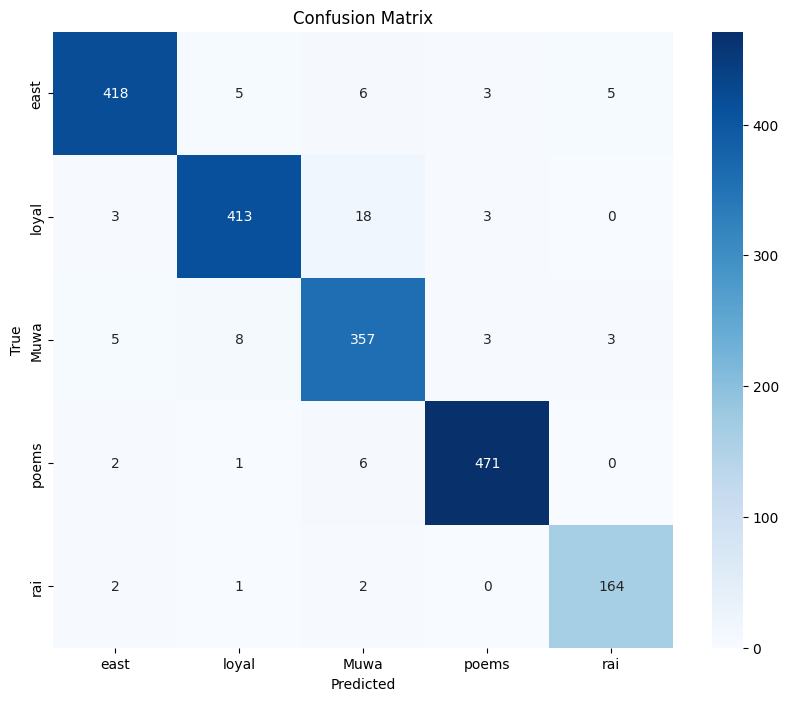

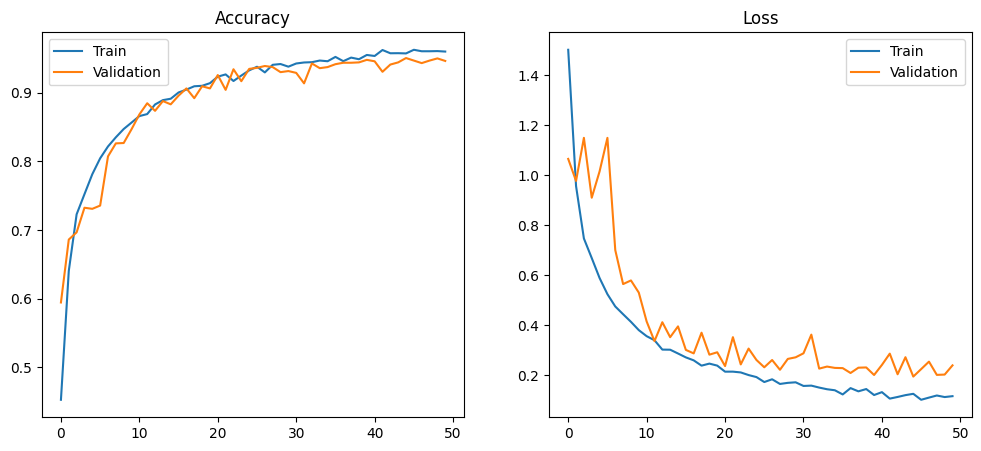

In [31]:
# Block 6: Evaluation and Results
# Load best saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/ArMGC_model.keras')

# Test evaluation
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc:.2%}")
print(f"📝 Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=genre_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

In [32]:
# Block 7: Audio Processing Configuration
# Audio configuration constants (assuming these are defined elsewhere)
SR = 22050  # sampling rate
DURATION = 30  # Changed from 10 to 30 seconds per clip
SAMPLES_PER_TRACK = SR * DURATION
N_MFCC = 13  # number of MFCCs
N_FFT = 2048
HOP_LENGTH = 5169  # Modified for 30-second clips: (22050*30)/5169 ≈ 128 → padded to 130

def extract_features(audio_signal):
    """Process audio signal instead of file path"""
    try:
        # Ensure correct length
        signal = librosa.util.fix_length(audio_signal, size=SAMPLES_PER_TRACK)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=signal, sr=SR, n_mfcc=N_MFCC,
                                   n_fft=N_FFT, hop_length=HOP_LENGTH)

        # Pad/trim to exact 130 time steps
        if mfcc.shape[1] < 130:
            mfcc = np.pad(mfcc, ((0,0), (0,130 - mfcc.shape[1])))
        else:
            mfcc = mfcc[:, :130]

        # Transpose and add channel dimension
        mfcc = mfcc.T[..., np.newaxis]  # (130, 13, 1)

        return mfcc

    except Exception as e:
        print(f"Feature extraction error: {str(e)}")
        return None

In [33]:
# Block 8: Audio Processing Function
def process_any_audio(file_path, chunk_size=30):  # Changed default chunk_size to 30
    try:
        # Load full audio
        print(f"Loading audio file: {file_path}")
        full_signal, sr = librosa.load(file_path, sr=SR)
        total_samples = len(full_signal)
        total_duration = total_samples / SR

        print(f"Audio duration: {total_duration:.2f} seconds")
        print(f"Processing in {chunk_size}-second chunks")

        predictions = []
        chunk_results = []  # To store individual chunk predictions

        # Process audio in 30-second chunks
        for start_sample in range(0, total_samples, SR*chunk_size):
            end_sample = min(start_sample + SR*chunk_size, total_samples)
            chunk_duration = (end_sample - start_sample) / SR

            # Skip chunks that are too short (less than 5 seconds)
            if chunk_duration < 5:
                print(f"Skipping final chunk ({chunk_duration:.2f}s) - too short")
                continue

            print(f"Processing chunk {len(predictions)+1}: {start_sample/SR:.2f}s - {end_sample/SR:.2f}s")

            chunk = full_signal[start_sample:end_sample]

            # Process chunk
            features = extract_features(chunk)
            if features is None:
                print(f"Skipping invalid chunk {start_sample/SR:.2f}s - {end_sample/SR:.2f}s")
                continue

            # Predict
            pred = model.predict(features[np.newaxis, ...], verbose=0)
            predicted_index = np.argmax(pred)
            predicted_genre = genre_names[predicted_index]
            confidence = float(pred[0][predicted_index])

            print(f"  Chunk result: {predicted_genre} (confidence: {confidence:.2f})")

            predictions.append(predicted_index)
            chunk_results.append({
                "start_time": start_sample/SR,
                "end_time": end_sample/SR,
                "genre": predicted_genre,
                "confidence": confidence,
                "all_confidences": {genre_names[i]: float(pred[0][i]) for i in range(len(genre_names))}
            })

        if not predictions:
            return "No valid predictions"

        # Get most common genre
        most_common_genre_index = np.bincount(predictions).argmax()
        most_common_genre = genre_names[most_common_genre_index]

        # Calculate average confidence for each genre
        genre_confidences = {}
        for chunk in chunk_results:
            for genre, conf in chunk["all_confidences"].items():
                if genre not in genre_confidences:
                    genre_confidences[genre] = []
                genre_confidences[genre].append(conf)

        avg_confidences = {genre: np.mean(confs) for genre, confs in genre_confidences.items()}
        sorted_confidences = sorted(avg_confidences.items(), key=lambda x: x[1], reverse=True)

        # Prepare result
        result = {
            "predicted_genre": most_common_genre,
            "prediction_count": {genre_names[i]: np.bincount(predictions)[i] if i < len(np.bincount(predictions)) else 0
                               for i in range(len(genre_names))},
            "average_confidences": sorted_confidences,
            "chunk_results": chunk_results
        }

        print("\n===== RESULTS =====")
        print(f"Predicted genre: {result['predicted_genre']}")
        print(f"Processed {len(chunk_results)} chunks of {chunk_size} seconds each")

        print("\nGenre distribution across chunks:")
        for genre, count in result['prediction_count'].items():
            if count > 0:
                print(f"  {genre}: {count} chunks ({count/len(chunk_results)*100:.1f}%)")

        print("\nAverage confidence scores:")
        for genre, conf in sorted_confidences:
            print(f"  {genre}: {conf*100:.2f}%")

        return result

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"Processing error: {str(e)}"

In [37]:
# Block 9: Testing
# Test with your file
result = process_any_audio('/content/drive/MyDrive/ArabicClips/test.wav', chunk_size=30)

if isinstance(result, dict):
    print("\nPredicted genre:", result["predicted_genre"])
else:
    print(result)  # Error message

Loading audio file: /content/drive/MyDrive/ArabicClips/test.wav
Audio duration: 327.56 seconds
Processing in 30-second chunks
Processing chunk 1: 0.00s - 30.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 2: 30.00s - 60.00s
  Chunk result: rai (confidence: 0.68)
Processing chunk 3: 60.00s - 90.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 4: 90.00s - 120.00s
  Chunk result: rai (confidence: 0.94)
Processing chunk 5: 120.00s - 150.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 6: 150.00s - 180.00s
  Chunk result: loyal (confidence: 0.77)
Processing chunk 7: 180.00s - 210.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 8: 210.00s - 240.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 9: 240.00s - 270.00s
  Chunk result: rai (confidence: 1.00)
Processing chunk 10: 270.00s - 300.00s
  Chunk result: loyal (confidence: 0.78)
Processing chunk 11: 300.00s - 327.56s
  Chunk result: rai (confidence: 0.84)

===== RESULTS =====
Predicte